# NST Preprocessing Experiment (NPE):
## Generating stats for basic data-based topic models

Calculating topic coherence and topic diversity on the topicset geneated by LDA and Top2Vec models from the basic dataset in NPE.

In [1]:
# Imports
import csv
import os
import random
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import Counter
import multiprocessing as mp
from joblib import Parallel, delayed
import itertools

from src.utils.file_management import (
    ROOT_PATH,
    load_subtitles,
    load_model_topics,
    write_word_frequencies_file,
    load_word_frequencies,
    write_word_co_frequencies_zip_file,
    load_zipped_word_co_frequencies)

from textPrep.settings.common import (
    word_frequency,
    word_co_frequency_document)

from textPrep.evaluation_metrics.evaluate_topic_set import compute_metrics

NST_SAMPLE_SIZE = 1000
PIPELINE = "basic"
NUM_PROC = mp.cpu_count() - 2
NUM_TOPIC_WORDS = 10

In [2]:
# Load file produced by current pipeline
folder_path_data = r"nst_preprocessing_experiment/preprocessed_data"
file_name =  f"npe_{NST_SAMPLE_SIZE}_{PIPELINE}"

subtitled_programs = load_subtitles(folder_path_data, file_name)

example_program_id = random.choice(list(subtitled_programs.keys()))
example_program_slice = 5

subtitled_programs[example_program_id][:example_program_slice]

['hei', 'kråkeklubben', 'kråkeklubben', 'venner', 'kråkeklubben']

In [3]:
# Load topics of LDA and Top2Vec models

folder_path_topics = r"nst_preprocessing_experiment/results/topics"

lda_topics = load_model_topics(folder_path_topics, file_name, model="lda", num_lda_topics=8)
top2vec_topics = load_model_topics(folder_path_topics, file_name, model="top2vec", top2vec_embedding="distiluse")

print("LDA first topic:")
print(lda_topics[0])
print("\nTop2Vec first topic:")
print(top2vec_topics[0])

LDA first topic:
['folk', 'tror', 'norge', 'vet', 'takk', 'kveld', 'barn', 'bedre', 'land', 'møte', 'gir', 'trenger', 'håper', 'velkommen', 'usa', 'hei', 'vanskelig', 'landet', 'trump', 'ønsker']

Top2Vec first topic:
['oooooh', 'hahaha', 'haha', 'ooo', 'takke', 'oh', 'uff', 'nff', 'ooh', 'takk', 'aha', 'takknemlig', 'hua', 'eh', 'ah', 'fatah', 'takker', 'what', 'whats', 'fhi', 'fuck', 'antakeligvis', 'hm', 'nesa', 'hval', 'hekk', 'huff', 'oi', 'thank', 'co', 'forhapentligvis', 'mmm', 'yeah', 'uskadd', 'takvam', 'hehe', 'velte', 'kjempeartig', 'kah', 'wow', 'nemnd', 'yes', 'sannsynligvis', 'aaa', 'bukk', 'haba', 'huk', 'khashoggi', 'ne', 'neppe']


In [4]:
# Calculate and save, or load, RAW data word frequencies to/from file

folder_path_frequencies = f"nst_preprocessing_experiment/results/word_frequencies/{PIPELINE}"
file_name_frequencies = f"npe_{NST_SAMPLE_SIZE}_{PIPELINE}_frequencies"

file_path_frequencies = os.path.join(ROOT_PATH, folder_path_frequencies, file_name_frequencies)

word_frequencies = {}

if os.path.exists(file_path_frequencies):
    word_frequencies = load_word_frequencies(folder_path_frequencies, file_name_frequencies)
else:
    word_frequencies = word_frequency({}, list(subtitled_programs.values()))
    write_word_frequencies_file(folder_path_frequencies, file_name_frequencies, word_frequencies)

example_frequency = random.choice(list(word_frequencies.keys()))
print(f"{example_frequency}: {word_frequencies[example_frequency]}")

pilsen: 2


In [5]:
# Calculate and save, or load, word co-frequencies to/from file

file_name_co_frequencies = f"npe_{NST_SAMPLE_SIZE}_{PIPELINE}_co_frequencies"

word_co_frequencies = Counter()

file_path_co_frequencies = os.path.join(ROOT_PATH, folder_path_frequencies, str(file_name_co_frequencies + ".pkl.zip"))

if os.path.exists(file_path_co_frequencies):
    word_co_frequencies = load_zipped_word_co_frequencies(folder_path_frequencies, file_name_co_frequencies)

else:
    print("Ready to create co_frequencies file!")
    chunk_size = 100
    for i in range(0, len(subtitled_programs.values()), chunk_size):

        doc_word_co_frequencies = []

        doc_word_co_frequencies = Parallel(n_jobs=NUM_PROC)(
            delayed(word_co_frequency_document)
            (Counter(), program) for program in
            itertools.islice(subtitled_programs.values(), i, i + chunk_size))
        print(f"Program {i}-{i + chunk_size} done!")
        
        for doc_word_co_frequency in doc_word_co_frequencies:
            word_co_frequencies.update(doc_word_co_frequency)
        print(f"Program {i}-{i + chunk_size} summed!")
    
    print("All freqs found! Writing Zip file")
    
    write_word_co_frequencies_zip_file(folder_path_frequencies, file_name_co_frequencies, word_co_frequencies)

    print("Zip file written! Finished!")

In [6]:
example_co_frequency = random.choice(list(word_co_frequencies.keys()))
print(f"{example_co_frequency}: {word_co_frequencies[example_co_frequency]}")

('dinglet', 'gangen'): 2


In [7]:
# Compute topic coherence and diversity of LDA and Top2Vec results on data

coherence_lda, diversity_lda = compute_metrics(
    lda_topics.values(), word_frequencies, word_co_frequencies, NUM_TOPIC_WORDS)
coherence_top2vec, diversity_top2vec = compute_metrics(
    top2vec_topics.values(), word_frequencies, word_co_frequencies, NUM_TOPIC_WORDS)


In [8]:
coherence_lda

0.8063765108908946

In [9]:
diversity_lda

0.3

In [10]:
coherence_top2vec

0.56342573796709

In [11]:
diversity_top2vec

1.0

In [12]:
# Check the stats for the dataset after running basic pipeline

models = ["LDA" if i % 2 == 0 else "Top2Vec" for i in range(0, 4)]
metrics = ["coherence" if i < 2 else "diversity" for i in range(0, 4)]
values = [
    coherence_lda,
    coherence_top2vec,
    diversity_lda,
    diversity_top2vec
    ]

stats = [models, metrics, values]
stats_tabulate = list(zip(*stats))
print(tabulate(stats_tabulate, headers=["Model", "Metric", "Value"], tablefmt="fancy_grid"))

╒═════════╤═══════════╤══════════╕
│ Model   │ Metric    │    Value │
╞═════════╪═══════════╪══════════╡
│ LDA     │ coherence │ 0.806377 │
├─────────┼───────────┼──────────┤
│ Top2Vec │ coherence │ 0.563426 │
├─────────┼───────────┼──────────┤
│ LDA     │ diversity │ 0.3      │
├─────────┼───────────┼──────────┤
│ Top2Vec │ diversity │ 1        │
╘═════════╧═══════════╧══════════╛


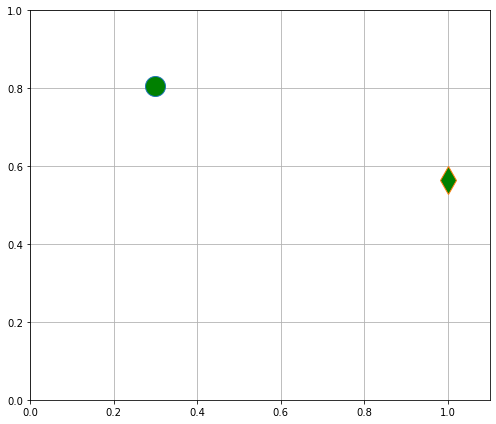

In [13]:
plt.rcParams["figure.figsize"] = [7.00, 6.00]
plt.rcParams["figure.autolayout"] = True
coherence = values[:2]
diversity = values[2:]
plt.xlim(0.0, 1.1)
plt.ylim(0.0, 1.0)
plt.grid()
plt.plot(diversity[0], coherence[0], marker="o", markersize=20, markerfacecolor="green")
plt.plot(diversity[1], coherence[1], marker="d", markersize=20, markerfacecolor="green")
plt.show()

In [14]:
# Save all topic stats to file

topic_stats_folder_path = r"../../nst_preprocessing_experiment/results/topic_stats/"
topic_stats_file_name = f"npe_{NST_SAMPLE_SIZE}_{PIPELINE}_topic_stats"
topic_stats_path = os.path.join(topic_stats_folder_path + topic_stats_file_name + r".csv")

TOPIC_STAT = "Topic stat"
VALUE = "Value"

with open(topic_stats_path, encoding="utf-8", mode="w", newline="") as topic_stats_file:
    header = [TOPIC_STAT, VALUE]
    writer = csv.DictWriter(topic_stats_file, fieldnames=header, delimiter=";")
    writer.writeheader()
    writer.writerow({TOPIC_STAT : "LDA_coherence", VALUE : coherence_lda})
    writer.writerow({TOPIC_STAT : "LDA_diversity", VALUE : diversity_lda})
    writer.writerow({TOPIC_STAT : "Top2Vec_coherence", VALUE : coherence_top2vec})
    writer.writerow({TOPIC_STAT : "Top2Vec_diversity", VALUE : diversity_top2vec})